## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import Dropout
from keras.regularizers import l1, l2, l1_l2
from keras.layers import BatchNormalization

# Dropout
def build_mlp_drop(input_shape, output_units=10, num_neurons=[512, 256, 128], drp_ratio=0.2):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = Dropout(drp_ratio)(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = Dropout(drp_ratio)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

# Regularizers
def build_mlp_reg(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=1e-8):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1(l1_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1(l1_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

# BatchNormalization
def build_mlp_bn(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95

In [7]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""

m = ['Dropout', 'Regularizers', 'BatchNormalization']

for method in m:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print(method)
    if method == 'Dropout':
        model = build_mlp_drop(input_shape=x_train.shape[1:])
    elif method == 'Regularizers':
        model = build_mlp_reg(input_shape=x_train.shape[1:])
    elif method == 'BatchNormalization':
        model = build_mlp_bn(input_shape=x_train.shape[1:])
    
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]

    exp_name_tag = "Exp-{}".format(method)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

W0804 21:12:16.145999  1044 deprecation_wrapper.py:119] From C:\Users\Hui\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0804 21:12:16.148000  1044 deprecation_wrapper.py:119] From C:\Users\Hui\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0804 21:12:16.172999  1044 deprecation_wrapper.py:119] From C:\Users\Hui\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0804 21:12:16.174000  1044 deprecation_wrapper.py:119] From C:\Users\Hui\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0804 21:12:16.176000  1044 deprecat

Dropout
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
__

W0804 21:12:16.401000  1044 deprecation.py:323] From C:\Users\Hui\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 6s 124us/step - loss: 2.1692 - acc: 0.1969 - val_loss: 1.9738 - val_acc: 0.3113
Epoch 2/50
50000/50000 [==============================] - 6s 118us/step - loss: 1.9743 - acc: 0.2808 - val_loss: 1.8618 - val_acc: 0.3407
Epoch 3/50
50000/50000 [==============================] - 5s 109us/step - loss: 1.8876 - acc: 0.3162 - val_loss: 1.7986 - val_acc: 0.3687
Epoch 4/50
50000/50000 [==============================] - 5s 108us/step - loss: 1.8319 - acc: 0.3403 - val_loss: 1.7306 - val_acc: 0.3895
Epoch 5/50
50000/50000 [==============================] - 5s 108us/step - loss: 1.7877 - acc: 0.3567 - val_loss: 1.6905 - val_acc: 0.4003
Epoch 6/50
50000/50000 [==============================] - 5s 109us/step - loss: 1.7532 - acc: 0.3715 - val_loss: 1.6658 - val_acc: 0.4106
Epoch 7/50
50000/50000 [==============================] - 5s 108us/step - loss: 1.7217 - acc: 0.3820 - val_loss: 1.6363 - 

50000/50000 [==============================] - 7s 135us/step - loss: 1.8157 - acc: 0.3652 - val_loss: 1.7651 - val_acc: 0.3781
Epoch 3/50
50000/50000 [==============================] - 7s 139us/step - loss: 1.7244 - acc: 0.3956 - val_loss: 1.6956 - val_acc: 0.4055
Epoch 4/50
50000/50000 [==============================] - 7s 137us/step - loss: 1.6609 - acc: 0.4174 - val_loss: 1.6425 - val_acc: 0.4262
Epoch 5/50
50000/50000 [==============================] - 7s 135us/step - loss: 1.6148 - acc: 0.4356 - val_loss: 1.6012 - val_acc: 0.4373
Epoch 6/50
50000/50000 [==============================] - 7s 138us/step - loss: 1.5775 - acc: 0.4463 - val_loss: 1.5729 - val_acc: 0.4443
Epoch 7/50
50000/50000 [==============================] - 7s 138us/step - loss: 1.5431 - acc: 0.4598 - val_loss: 1.5673 - val_acc: 0.4467
Epoch 8/50
50000/50000 [==============================] - 7s 134us/step - loss: 1.5145 - acc: 0.4698 - val_loss: 1.5257 - val_acc: 0.4659
Epoch 9/50
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 7s 132us/step - loss: 1.8797 - acc: 0.3557 - val_loss: 1.8760 - val_acc: 0.3653
Epoch 2/50
50000/50000 [==============================] - 6s 120us/step - loss: 1.5492 - acc: 0.4558 - val_loss: 1.6562 - val_acc: 0.4099
Epoch 3/50
50000/50000 [==============================] - 6s 119us/step - loss: 1.4365 - acc: 0.4978 - val_loss: 1.5642 - val_acc: 0.4384
Epoch 4/50
50000/50000 [==============================] - 6s 118us/step - loss: 1.3636 - acc: 0.5226 - val_loss: 1.5229 - val_acc: 0.4576
Epoch 5/50
50000/50000 [==============================] - 6s 119us/step - loss: 1.3035 - acc: 0.5446 - val_loss: 1.5404 - val_acc: 0.4566
Epoch 6/50
50000/50000 [==============================] - 6s 119us/step - loss: 1.2503 - acc: 0.5649 - val_loss: 1.5456 - val_acc: 0.4588
Epoch 7/50
50000/50000 [==============================] - 6s 120us/step - loss: 1.2061 - acc: 0.5803 - val_loss: 1.4753 - 

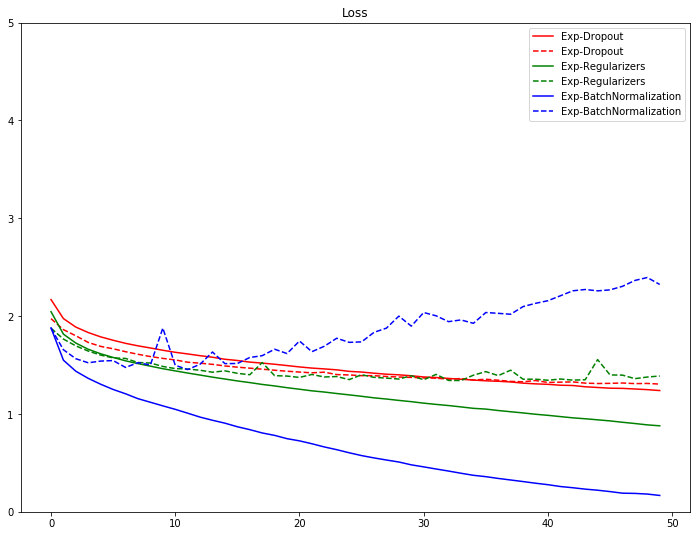

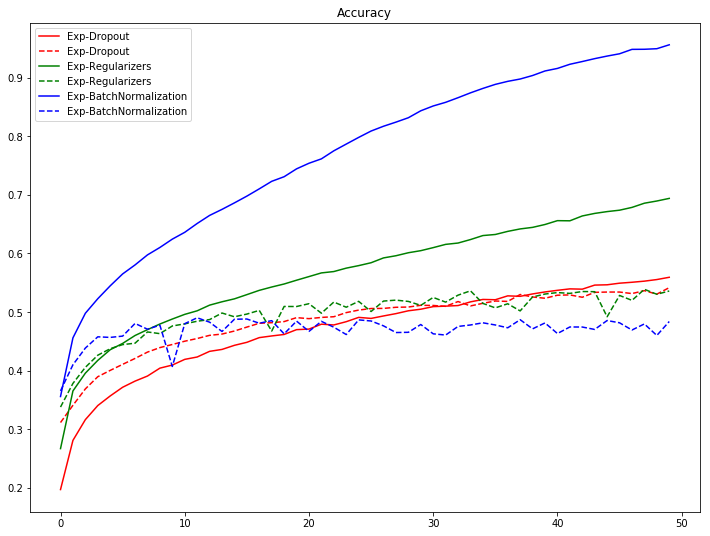

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k", "c"]

plt.figure(figsize=(12,9))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(12,9))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()